# 1D EULER SYSTEM SOLVER

In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## IMPLEMENTATION

In [161]:
class solver:
    
    class laser():
        
        def __init__(self, wavelength, energy, radius, t_0, fwhm):
            self.wavelength = wavelength                   # laser wavelength
            self.energy = energy                           # laser energy
            self.radius = radius                           # laser radius
            self.t_0 = t_0                                 # time at which laser reaches peak intensity
            self.fwhm = fwhm                               # laser duration at FWHM 
            
        def evaluate_laser(self, t):
            intensity = 0.8 / (np.pi**(3/2) * self.radius**2) * 2 * np.sqrt(np.log(2)) / self.fwhm * self.energy
            return intensity * np.exp(-(t - self.t_0)**2 / (self.fwhm / (2.0 * np.sqrt(np.log(2.0))))**2)
    
    def __init__(self, a, b, n_cells, c = 1.0):
        self.x = np.zeros(n_cells + 3)                     # grid nodes
        if c != 1.0:
            x0 = (b - a) * (c - 1) / (c**(n_cells + 3) - 1)
        else:
            x0 = (b - a) / n_cells
        self.x[0] = a
        self.x[1] = a + x0
        for i in range(1, n_cells + 2):
            self.x[i+1] = self.x[i] + c * (self.x[i] - self.x[i-1])
        self.u = np.zeros(n_cells + 3)                     # velocity
        self.rho = np.zeros(n_cells + 2)                       # density
        self.p = np.zeros(n_cells + 2)                         # pressure
        self.T = np.zeros(n_cells + 2)                         # temperature
        self.E = np.zeros(n_cells + 2)                         # energy
        self.q = np.zeros(n_cells + 2)                         # artificial viscosity
        self.L = np.zeros(n_cells + 3)                     # laser energy flux
        self.gamma = 5.0 / 3.0                             # adiabatic index (ratio of specific heats)
        self.laser = None                                  # laser datastructure
        self.atomic_weight = 1.0                           # standard atomic weight
        self.ionization = 1.0
        self.bc = "absorbing"
        
    def set_gamma(self, gamma):
        self.gamma = gamma
        
    def set_boundary_conditions(self, bc):
        self.bc = bc
        
    def set_laser(self, wavelength, energy, radius, t_0, fwhm):
        self.laser = solver.laser(wavelength, energy, radius, t_0, fwhm)
        
    def set_atomic_weight(self, atomic_weight):
        self.atomic_weight = atomic_weight
        
    def set_ionization(self, ionization):
        self.ionization = ionization
        
    def calculate_critical_density(self):
        return 1.86e-11 * self.atomic_weight / (self.ionization * self.laser.wavelength**2)
        
    def initialize_riemann_problem(self, variable, interface, init_values):
        indices = [0, variable.size]
        for x_0 in interface:
            indices.insert(-1, self.x[self.x <= x_0].size)          
        for i in range(len(indices)-1):
            values = np.asarray(init_values[i])
            if values.size == 1:
                variable[indices[i]:indices[i+1]] = values
            else:
                variable[indices[i]:indices[i+1]] = values[indices[i]:indices[i+1]]
        
    def run(self, t_start, t_end, CFL = 0.25, c_a = 0.5, c_1 = 1.0, c_2 = 1.0):
        
        t = t_start   

        # calculate initial energy using equation of state for ideal gas:
        if np.nonzero(self.T)[0].size != 0:
            self.E = self.T / (self.atomic_weight * (self.gamma - 1) / (self.ionization + 1) * 1.0365e-12)
            self.p = self.E * self.rho * (self.gamma - 1)
        else:
            self.E = self.p / (self.rho * (self.gamma - 1))
            self.T = self.E * (self.atomic_weight * (self.gamma - 1) / (self.ionization + 1) * 1.0365e-12)
        
        u_new = np.copy(self.u)
        
        # calculate cell mass:
        m = self.rho * (self.x[1:] - self.x[:-1])
        
        # simulation loop:
        while(t <= t_end):

            # update cell volume:
            V = self.x[1:] - self.x[:-1]

            # calculate speed of sound:
            u_s = np.sqrt((self.gamma - 1) * self.gamma * self.E)

            # calculate timestep:
            dt = CFL * np.min(V / u_s)

            # calculate artificial viscosity:
            self.q.fill(0.0)
            for i in range(1, self.q.size - 1):
                if self.u[i+1] >= self.u[i]:
                    self.q[i] = 0.0
                else:
                    r_l = (V[i] * (self.u[i+2] - self.u[i+1])) / (V[i+1] * (self.u[i+1] - self.u[i]))
                    r_r = (V[i] * (self.u[i] - self.u[i-1])) / (V[i-1] * (self.u[i+1] - self.u[i]))
                    phi = max(0.0, min(0.5 * (r_l + r_r), 2.0 * r_l, 2.0 * r_r, 1.0))
                    q_kur = self.rho[i] * np.abs(self.u[i+1] - self.u[i]) * (c_2 * (self.gamma + 1.0) / 4.0 \
                            * np.abs(self.u[i+1] - self.u[i]) + np.sqrt((c_2 * (self.gamma + 1.0) / 4.0 \
                            * (self.u[i+1] - self.u[i]))**2 + (c_1 * u_s[i])**2))
                    self.q[i] = q_kur * (1.0 - phi) 

            # update velocity:
            u_new[1:-1] = self.u[1:-1] - 2.0 * dt * (self.p[1:] - self.p[:-1] + self.q[1:] - self.q[:-1]) \
                          / (m[1:] + m[:-1])
                
            # apply boundary conditions:
            if self.bc == "free":
                u_new[0] = u_new[1]
                u_new[-1] = self.u[-1] - 2.0 * dt * (-self.p[-2] - self.q[-2]) / (m[-1] + m[-2])
            
            if self.bc == "reflective":
                u_new[0] = 0.0
                u_new[1] = 0.0
                u_new[-1] = 0.0
                u_new[-2] =  0.0
                
            if self.bc == "absorbing":
                u_new[0] = u_new[1]
                u_new[-1] = u_new[-2]

            # update grid nodes:
            x_new = self.x + dt * (u_new + self.u) / 2.0
            
            # calculate absorption of laser pulse:
            if self.laser != None:
                rho_critical = np.argwhere(self.rho > self.calculate_critical_density())
                if rho_critical.size == 0:
                    self.L[:] = -c_a * self.laser.evaluate_laser(t)
                else:
                    self.L[0:rho_critical[-1][0]] = 0.0
                    self.L[rho_critical[-1][0]:self.L.size] = -c_a * self.laser.evaluate_laser(t)

            # update energy:
            E_new = self.E - 0.5 * dt / m * (self.p + self.q) * (u_new[1:] - u_new[:-1] + \
                    self.u[1:] - self.u[:-1]) - dt / m * (self.L[1:] + self.L[:-1])
            if self.bc == "reflective":
                E_new[0] = E_new[1]
                E_new[-1] = E_new[-2]

            # update density:
            rho_new = m / (x_new[1:] - x_new[:-1])
            if self.bc == "reflective":
                rho_new[0] = rho_new[1]
                rho_new[-1] = rho_new[-2]

            # update pressure:
            p_new = E_new * rho_new * (self.gamma - 1)
            if self.bc == "reflective":
                p_new[0] = p_new[1] 
                p_new[-1] = p_new[-2] 
            
            # update temperature:
            T_new = E_new * (self.atomic_weight * (self.gamma - 1) / (self.ionization + 1) * 1.0365e-12)

            # assign new values to old ones:
            self.u = u_new
            self.x = x_new
            self.E = E_new
            self.rho = rho_new
            self.p = p_new
            self.T = T_new

            # update time:
            t += dt
            
    def plot(self, variable, name = "", centered = False):
        fig, ax = plt.subplots()
        xx = (self.x[1:] + self.x[:-1]) / 2.0 if centered else self.x
        ax.plot(xx, variable)
        ax.set_xlabel("x")
        ax.set_ylabel(name)

## EXAMPLES

### Riemann problem 1:

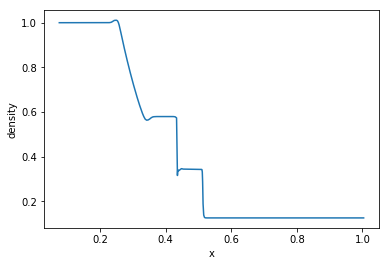

In [158]:
s = solver(a = 0.0, b = 1.0, n_cells = 400)
s.set_gamma(1.4)
s.initialize_riemann_problem(s.p, interface = [0.3], init_values = [1.0, 0.1])
s.initialize_riemann_problem(s.rho, interface = [0.3], init_values = [1.0, 0.125])
s.initialize_riemann_problem(s.u, interface = [0.3], init_values = [0.75, 0.0])
s.run(t_start = 0.0, t_end = 0.1)
s.plot(s.rho, name = "density", centered = True)

### Riemann problem 2:

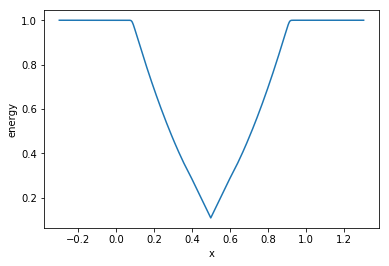

In [159]:
s = solver(a = 0.0, b = 1.0, n_cells = 400)
s.set_gamma(1.4)
s.initialize_riemann_problem(s.p, interface = [], init_values = [0.4])
s.initialize_riemann_problem(s.rho, interface = [], init_values = [1.0])
s.initialize_riemann_problem(s.u, interface = [0.5], init_values = [-2.0, 2.0])
s.run(t_start = 0.0, t_end = 0.15)
s.plot(s.E, name = "energy", centered = True)

### Woodward-Collela (blast wave):

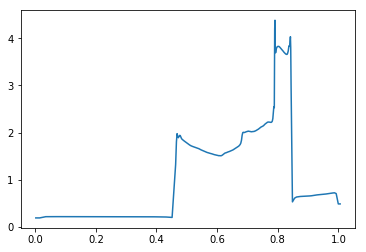

In [156]:
s = solver(a = 0.0, b = 1.0, n_cells = 250)
s.set_gamma(1.4)
s.set_boundary_conditions("reflective")
s.initialize_riemann_problem(s.p, interface = [0.1, 0.9], init_values = [1000.0, 0.01, 100.0])
s.initialize_riemann_problem(s.rho, interface = [], init_values = [1.0])
s.initialize_riemann_problem(s.u, interface = [], init_values = [0.0])
s.run(t_start = 0.0, t_end = 1.8)
s.plot(s.rho, name = "density", centered = True)

### Shu-Osher (entropy shock wave):

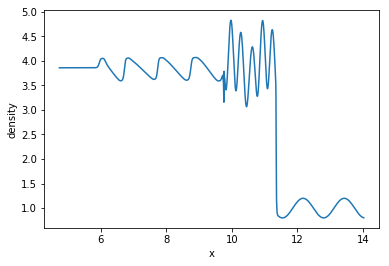

In [160]:
s = solver(a = 0.0, b = 14.0, n_cells = 725)
s.set_gamma(1.4)
s.initialize_riemann_problem(s.p, interface = [5.0], init_values = [10.33333, 1.0])
s.initialize_riemann_problem(s.rho, interface = [5.0], init_values = [3.857143, 1.0 + 0.2 * np.sin(5.0 * s.x - 9.0)])
s.initialize_riemann_problem(s.u, interface = [5.0], init_values = [2.629369, 0.0])
s.run(t_start = 0.0, t_end = 1.8)
s.plot(s.rho, name = "density", centered = True)

### Laser-plasma interaction:

In [162]:
s = solver(a = 0.0e-4, b = 40.0e-4, n_cells = 400, c = 0.99)
s.set_gamma(5.0 / 3.0)
s.set_boundary_conditions("free")
s.initialize_riemann_problem(s.rho, interface = [], init_values = [2.7])
s.initialize_riemann_problem(s.u, interface = [], init_values = [0.0])
s.initialize_riemann_problem(s.T, interface = [], init_values = [0.003])
s.set_laser(wavelength = 1.315e-4, energy = 390.0e7, radius = 100.0e-4, t_0 = 400.0e-12, fwhm = 400.0e-12)
s.set_atomic_weight(27)
s.set_ionization(13)
s.run(t_start = 0.0, t_end = 400.0e-12, CFL = 0.19, c_a = 0.5)

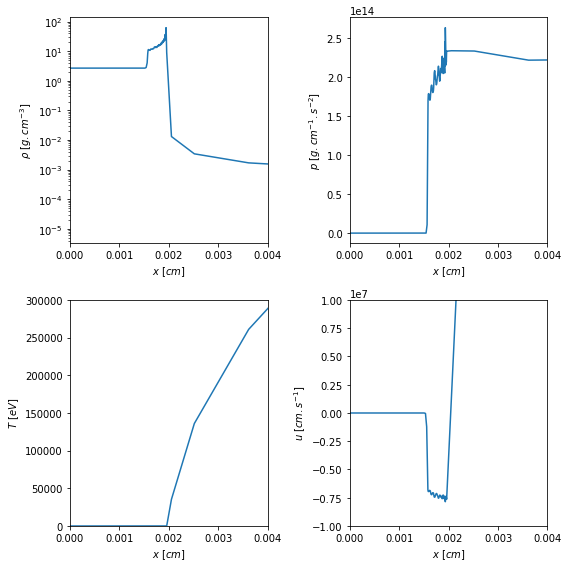

In [163]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].semilogy((s.x[1:] + s.x[:-1]) / 2.0, s.rho)
ax[0][0].set_xlim(0.0, 0.004)
ax[0][0].set_xlabel(r"$ x \ [cm] $")
ax[0][0].set_ylabel(r"$ \rho \ [g . cm^{-3}] $")

ax[0][1].plot((s.x[1:] + s.x[:-1]) / 2.0, s.p)
ax[0][1].set_xlim(0.0, 0.004)
ax[0][1].set_xlabel(r"$ x \ [cm] $")
ax[0][1].set_ylabel(r"$ p \ [g . cm^{-1} . s^{-2}] $")

ax[1][0].plot((s.x[1:] + s.x[:-1]) / 2.0, s.T)
ax[1][0].set_xlim(0.0, 0.004)
ax[1][0].set_ylim(0.0, 3e5)
ax[1][0].set_xlabel(r"$ x \ [cm] $")
ax[1][0].set_ylabel(r"$ T \ [eV] $")

ax[1][1].plot(s.x, s.u)
ax[1][1].set_xlim(0.0, 0.004)
ax[1][1].set_ylim(-0.01e9, 0.1e8)
ax[1][1].set_xlabel(r"$ x \ [cm] $")
ax[1][1].set_ylabel(r"$ u \ [cm . s^{-1}] $")

fig.tight_layout()